In [2]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import umap.umap_ as umap

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(1)
random.seed(1)

In [3]:
import util
import importlib
importlib.reload(util)

N_genes, N_dims, gpt_embeddings = util.retrieve_gpt_gene_embeddings()
gene_info = util.retrieve_gene_info()
gene_info.head()

,Unnamed: 0,ensembl_id,gene_name,gene_type
0,0,ENSG00000000003,TSPAN6,protein_coding
1,1,ENSG00000000005,TNMD,protein_coding
2,2,ENSG00000000419,DPM1,protein_coding
3,3,ENSG00000000457,SCYL3,protein_coding
4,4,ENSG00000000460,C1orf112,protein_coding


In [4]:
gpt_gene_names = list(gpt_embeddings.keys())
gene_info_names = gene_info["gene_name"]
gene_names = set(gpt_gene_names) & set(gene_info_names)
print("# common genes:", len(gene_names))

### keep only genes with both gpt embeddings and gene info
gpt_gene_names = {k:v for k,v in gpt_embeddings.items() if k in gene_names}
gene_info = gene_info[gene_info["gene_name"].isin(gene_names)]

# common genes: 31309


In [5]:
gene_type_counts = gene_info["gene_type"].value_counts()
threshold = 0.005 * gene_type_counts.sum()
gene_type_counts_grouped = gene_type_counts.copy()
gene_type_counts_grouped[gene_type_counts < threshold] = 0
gene_type_counts_grouped["Other"] = gene_type_counts[gene_type_counts < threshold].sum()
gene_type_counts_grouped = gene_type_counts_grouped[gene_type_counts_grouped > 0]
print("# non-filtered gene types:", len(gene_type_counts_grouped))
print("# genes / gene type:", min(gene_type_counts_grouped))

# non-filtered gene types: 12
# genes / gene type: 276


### Gene Type Distribution

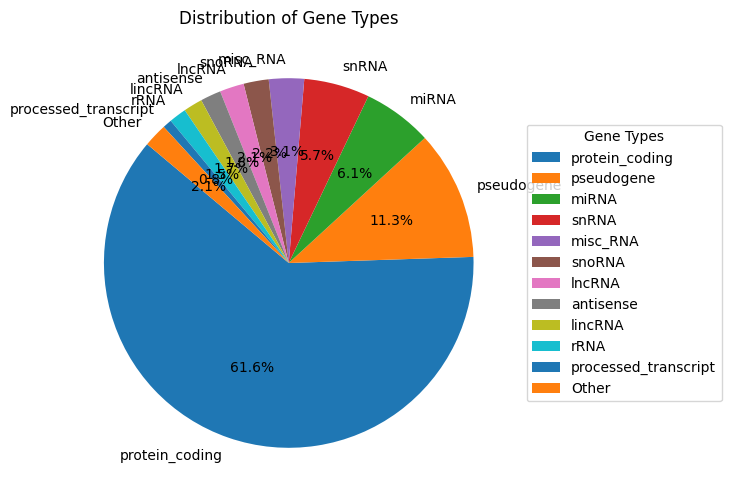

In [6]:
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    gene_type_counts_grouped, labels=gene_type_counts_grouped.index, autopct='%1.1f%%', startangle=140
)

plt.legend(wedges, gene_type_counts_grouped.index, title="Gene Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("Distribution of Gene Types")
plt.show()

### UMAP

In [29]:
N_genes_per_type = min(gene_type_counts_grouped)
sampled_gene_infos = []
for gene_type_name, gene_type_count in gene_type_counts_grouped.items():
    if gene_type_name == "Other":
        continue
    assert gene_type_count >= N_genes_per_type
    sampled_df = gene_info[gene_info["gene_type"] == gene_type_name].sample(n=gene_type_count, random_state=1)
    # sampled_df = gene_info[gene_info["gene_type"] == gene_type_name].sample(n=N_genes_per_type, random_state=1)
    sampled_gene_infos.append(sampled_df)
balanced_gene_info = pd.concat(sampled_gene_infos, ignore_index=True)
balanced_gene_info

,Unnamed: 0,ensembl_id,gene_name,gene_type
0,14974,ENSG00000179913,B3GNT3,protein_coding
1,15458,ENSG00000182334,OR5P3,protein_coding
2,15877,ENSG00000183908,LRRC55,protein_coding
3,1089,ENSG00000069509,FUNDC1,protein_coding
4,20660,ENSG00000204822,MRPL53,protein_coding
...,...,...,...,...
33808,37689,ENSG00000237050,TRIM31-AS1,processed_transcript
33809,50252,ENSG00000258644,SYNJ2BP-COX16,processed_transcript
33810,24328,ENSG00000215769,hsa-mir-6080,processed_transcript
33811,42029,ENSG00000244695,HCG17,processed_transcript


In [30]:
balanced_gene_names = balanced_gene_info["gene_name"]
balanced_gene_types = balanced_gene_info["gene_type"]
balanced_gene_embeddings = np.array([gpt_embeddings[gene] for gene in balanced_gene_names])
balanced_gene_info_dict = balanced_gene_info.set_index("gene_name")["gene_type"].to_dict()
gene_types = [balanced_gene_info_dict[gene] for gene in balanced_gene_names]

In [31]:
reducer = umap.UMAP(n_components=2, random_state=1)
embedding_2d = reducer.fit_transform(balanced_gene_embeddings)

/Users/dustinm/projects/GenePT-test/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dustinm/projects/GenePT-test/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


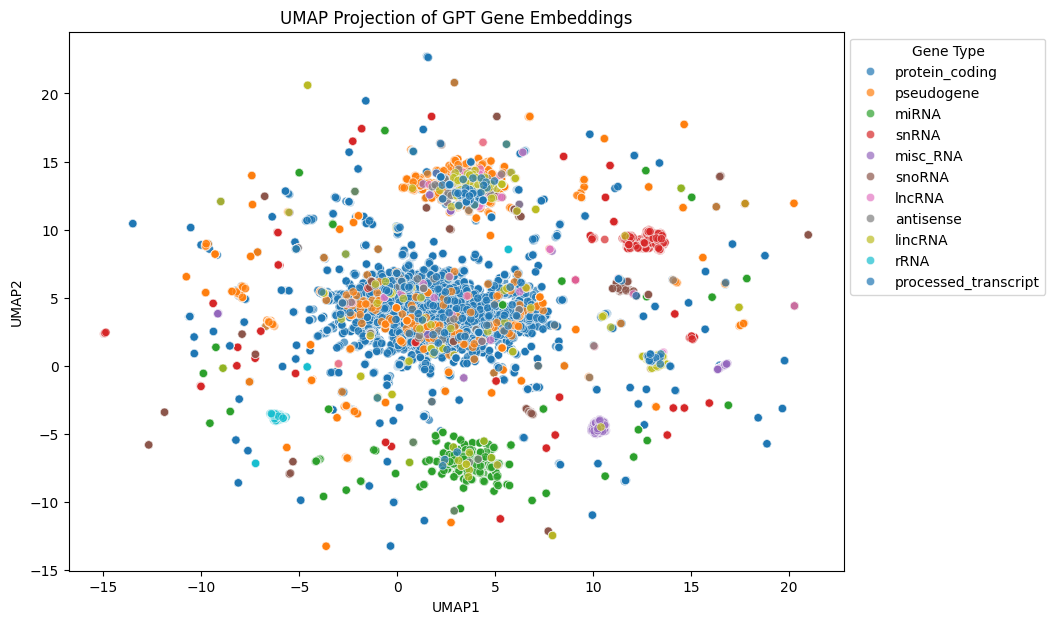

In [32]:
umap_df = pd.DataFrame(embedding_2d, columns=["UMAP1", "UMAP2"])
umap_df["gene_name"] = balanced_gene_names
umap_df["gene_type"] = balanced_gene_types

plt.figure(figsize=(10, 7))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="gene_type", palette="tab10", alpha=0.7)

plt.title("UMAP Projection of GPT Gene Embeddings")
plt.legend(title="Gene Type", bbox_to_anchor=(1, 1))
plt.show()

### Logistic Regression

In [33]:
X_list = balanced_gene_embeddings
y_list = balanced_gene_types
print("Data Dimensions:", np.array(X_list).shape, np.array(y_list).shape)

X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size=0.30, random_state=1)

print(f"Training set size (X_train): {len(X_train)}")
print(f"Test set size (X_test): {len(X_test)}")

Data Dimensions: (33813, 1536) (33813,)
Training set size (X_train): 23669
Test set size (X_test): 10144


In [37]:
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred_lr,y_test))

Accuracy:  0.9401616719242902


<Figure size 600x600 with 0 Axes>

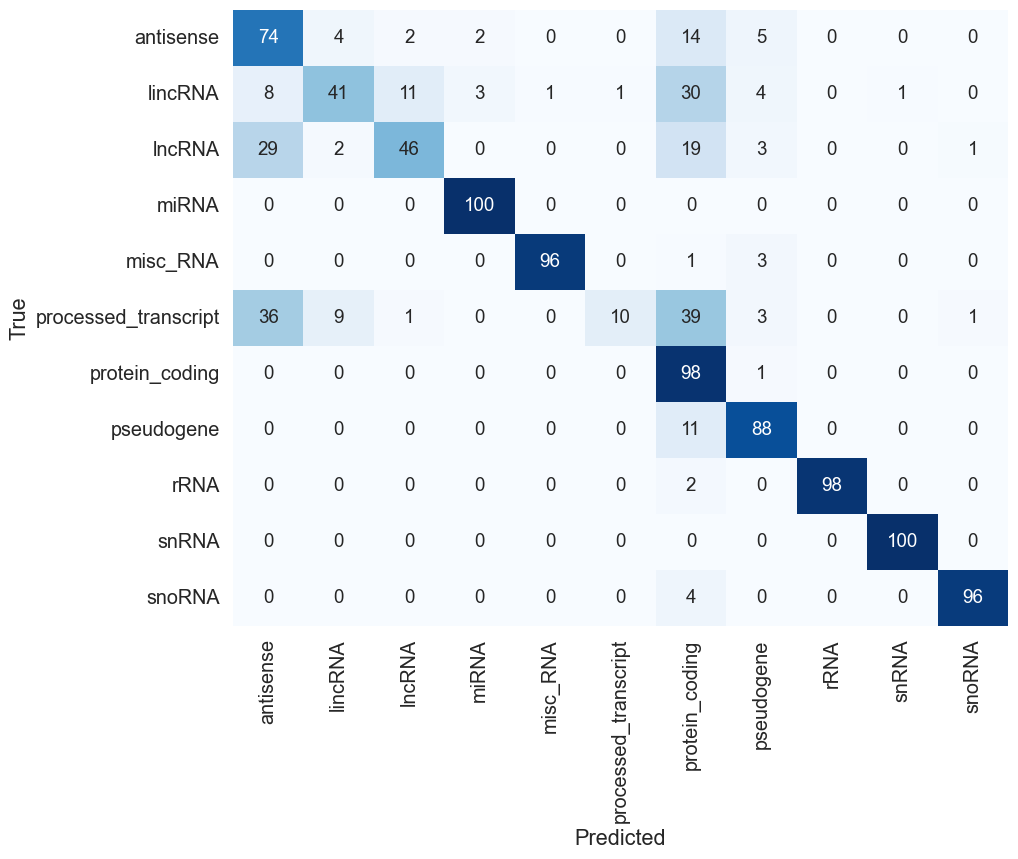

In [38]:
def plot_normalized_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a normalized confusion matrix using seaborn.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize by row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # replace nan with 0
    cm_normalized = cm_normalized * 100  # convert to percentage
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.0f', annot_kws={'fontsize': 13.5},
                cmap='Blues', xticklabels=classes, yticklabels=classes,cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plt.figure(figsize=(6,6))
sns.set(font_scale=1.3)
plot_normalized_confusion_matrix(np.array(y_test),y_pred_lr,np.unique(y_list))